# Universidad Del Valle de Guatemala
## Deep Learning
### Proyecto Final: Red Neuronal que predice el ganador de un partido de la liga BBVA.
#### Integrantes: 
- Roberto Rios 20979
- Javier Mombiela 20067

#### Importación de librerias

In [104]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.model_selection import train_test_split, KFold

#### Carga de data

In [105]:
data = pd.read_csv('temporadas.csv')

Visualizacion de data

In [106]:
print(data.count())
data

Date        3800
HomeTeam    3800
AwayTeam    3800
FTHG        3800
FTAG        3800
FTR         3800
HTHG        3800
HTAG        3800
HTR         3800
HS          3800
AS          3800
HST         3800
AST         3800
HF          3800
AF          3800
HC          3800
AC          3800
HY          3800
AY          3800
HR          3800
AR          3800
dtype: int64


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,18/08/13,Barcelona,Levante,7,0,H,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,18/08/13,Osasuna,Granada,1,2,A,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,04/06/2023,Betis,Valencia,1,1,D,1,0,H,8,...,3,3,11,11,5,4,3,0,0,1
3796,04/06/2023,Celta,Barcelona,2,1,H,1,0,H,12,...,9,2,13,9,2,4,2,2,0,0
3797,04/06/2023,Elche,Cadiz,1,1,D,0,1,A,12,...,5,3,18,8,7,4,4,3,0,0
3798,04/06/2023,Espanol,Almeria,3,3,D,1,1,D,12,...,8,4,11,12,7,6,2,3,0,0


In [107]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

C:\Users\rjmom\AppData\Local\Temp\ipykernel_20752\1555408434.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
HTHG                 int64
HTAG                 int64
HTR                 object
HS                   int64
AS                   int64
HST                  int64
AST                  int64
HF                   int64
AF                   int64
HC                   int64
AC                   int64
HY                   int64
AY                   int64
HR                   int64
AR                   int64
dtype: object

Comprobar si hay valores nulos o faltantes en el conjunto de datos

In [108]:
print(data.isnull().sum())

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


#### Preprocesamiento de datos

Codificacion de etiquetas para los equipos y variable objeitov FTR (Full Time Result)

In [109]:
team_label_encoder = LabelEncoder()
data['HomeTeam'] = team_label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = team_label_encoder.fit_transform(data['AwayTeam'])

result_label_encoder = LabelEncoder()
data['FTR'] = result_label_encoder.fit_transform(data['FTR'])

Ver la codificacion de cada variable

In [110]:
team_mapping = dict(zip(team_label_encoder.classes_, team_label_encoder.transform(team_label_encoder.classes_)))
print(team_mapping)

{'Alaves': 0, 'Almeria': 1, 'Ath Bilbao': 2, 'Ath Madrid': 3, 'Barcelona': 4, 'Betis': 5, 'Cadiz': 6, 'Celta': 7, 'Cordoba': 8, 'Eibar': 9, 'Elche': 10, 'Espanol': 11, 'Getafe': 12, 'Girona': 13, 'Granada': 14, 'Huesca': 15, 'La Coruna': 16, 'Las Palmas': 17, 'Leganes': 18, 'Levante': 19, 'Malaga': 20, 'Mallorca': 21, 'Osasuna': 22, 'Real Madrid': 23, 'Sevilla': 24, 'Sociedad': 25, 'Sp Gijon': 26, 'Valencia': 27, 'Valladolid': 28, 'Vallecano': 29, 'Villarreal': 30}


In [111]:
result_mapping = dict(zip(result_label_encoder.classes_, result_label_encoder.transform(result_label_encoder.classes_)))
print(result_mapping)

{'A': 0, 'D': 1, 'H': 2}


Visualizar las primeras filas para comprobar la codificacion

In [112]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2013-08-17,25,12,2,0,2,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,2013-08-17,27,20,1,0,2,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,2013-08-17,28,2,1,2,0,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,2013-08-18,4,19,7,0,2,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,2013-08-18,22,14,1,2,0,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0


#### Agregar estadisticas a la data

In [113]:
grouped_data = data.groupby('HomeTeam')
group = grouped_data.get_group(4)
group

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
3,2013-08-18,4,19,7,0,2,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
31,2013-09-14,4,24,3,2,2,1,0,H,19,...,10,2,12,17,6,9,2,5,0,0
51,2013-09-24,4,25,4,1,2,3,0,H,23,...,9,5,6,12,6,1,0,1,0,0
72,2013-05-10,4,28,4,1,2,1,1,D,21,...,8,1,7,15,7,4,0,3,0,0
91,2013-10-26,4,23,2,1,2,1,0,H,12,...,5,6,19,16,4,3,2,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,2023-04-23,4,3,1,0,2,1,0,H,13,...,4,3,15,16,3,3,4,7,0,0
3733,2023-04-29,4,5,4,0,2,3,0,H,15,...,8,1,10,9,10,0,0,2,0,1
3741,2023-02-05,4,22,1,0,2,0,0,D,21,...,4,2,7,10,11,0,0,0,0,1
3765,2023-05-20,4,25,1,2,0,0,1,A,13,...,4,6,8,16,8,2,4,4,0,0


Funcion para determinar el rolling average de los ultimos 10 partidos

In [114]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(10, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [115]:
cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
new_cols = [f'{col}_avg' for col in cols]
new_cols

['FTHG_avg',
 'FTAG_avg',
 'HTHG_avg',
 'HTAG_avg',
 'HS_avg',
 'AS_avg',
 'HST_avg',
 'AST_avg',
 'HF_avg',
 'AF_avg',
 'HC_avg',
 'AC_avg',
 'HY_avg',
 'AY_avg',
 'HR_avg',
 'AR_avg']

In [116]:
rolling_averages(group, cols, new_cols)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST_avg,AST_avg,HF_avg,AF_avg,HC_avg,AC_avg,HY_avg,AY_avg,HR_avg,AR_avg
206,2014-01-26,4,20,3,0,2,1,0,H,23,...,7.9,2.9,12.0,16.3,6.9,4.3,1.2,2.8,0.1,0.1
256,2014-02-03,4,1,4,1,2,2,1,H,29,...,8.4,2.9,12.6,16.0,7.5,4.3,1.2,2.8,0.1,0.1
232,2014-02-15,4,29,6,0,2,2,0,H,21,...,8.7,3.1,12.7,15.7,8.1,4.3,1.3,2.9,0.1,0.1
350,2014-03-05,4,12,2,2,1,1,1,D,21,...,8.4,3.4,11.8,15.1,8.4,4.5,1.2,2.6,0.1,0.1
275,2014-03-16,4,22,7,0,2,3,0,H,20,...,8.2,3.7,11.9,14.0,8.9,3.9,1.3,2.4,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,2023-05-02,4,24,3,0,2,0,0,D,16,...,5.4,2.6,12.4,11.7,6.2,2.4,2.2,2.7,0.1,0.4
3656,2023-05-03,4,27,1,0,2,1,0,H,13,...,5.7,2.2,11.4,12.1,6.8,1.9,1.9,2.9,0.1,0.3
3765,2023-05-20,4,25,1,2,0,0,1,A,13,...,5.6,2.2,10.7,12.3,6.5,2.1,1.9,2.8,0.2,0.3
3784,2023-05-28,4,21,3,0,2,2,0,H,28,...,5.3,2.5,10.8,12.6,7.2,2.1,2.1,3.0,0.2,0.3


In [117]:
data = data.groupby('HomeTeam').apply(lambda x: rolling_averages(x, cols, new_cols))
data = data.groupby('AwayTeam').apply(lambda x: rolling_averages(x, cols, new_cols))

data = data.droplevel('AwayTeam')
data.head()

,,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST_avg,AST_avg,HF_avg,AF_avg,HC_avg,AC_avg,HY_avg,AY_avg,HR_avg,AR_avg
HomeTeam,,,,,,,,,,,,,,,,,,,,,,
23,1425,2017-02-04,23,0,3,0,2,1,0,H,18,...,5.2,2.9,14.1,13.4,8.6,2.5,2.6,3.2,0.0,0.3
16,1358,2017-02-18,16,0,0,1,0,0,0,D,16,...,4.6,3.1,14.3,13.7,8.0,2.6,2.4,2.8,0.0,0.3
17,1465,2017-04-23,17,0,1,1,1,1,0,H,14,...,4.6,3.2,13.8,14.0,8.7,2.8,2.4,2.9,0.0,0.3
5,1484,2017-04-30,5,0,1,4,0,1,0,H,11,...,4.3,3.6,14.7,13.9,7.0,3.5,2.8,2.6,0.1,0.3
26,1345,2017-05-02,26,0,2,4,0,0,1,A,12,...,4.4,4.0,14.7,14.2,6.7,3.1,2.7,2.8,0.1,0.3


In [118]:
data.index = range(data.shape[0])
data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST_avg,AST_avg,HF_avg,AF_avg,HC_avg,AC_avg,HY_avg,AY_avg,HR_avg,AR_avg
0,2017-02-04,23,0,3,0,2,1,0,H,18,...,5.2,2.9,14.1,13.4,8.6,2.5,2.6,3.2,0.0,0.3
1,2017-02-18,16,0,0,1,0,0,0,D,16,...,4.6,3.1,14.3,13.7,8.0,2.6,2.4,2.8,0.0,0.3
2,2017-04-23,17,0,1,1,1,1,0,H,14,...,4.6,3.2,13.8,14.0,8.7,2.8,2.4,2.9,0.0,0.3
3,2017-04-30,5,0,1,4,0,1,0,H,11,...,4.3,3.6,14.7,13.9,7.0,3.5,2.8,2.6,0.1,0.3
4,2017-05-02,26,0,2,4,0,0,1,A,12,...,4.4,4.0,14.7,14.2,6.7,3.1,2.7,2.8,0.1,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2023-04-03,1,30,0,2,0,0,0,D,6,...,4.9,3.5,14.3,9.5,7.3,4.4,2.5,1.6,0.0,0.1
3176,2023-04-23,24,30,2,1,2,1,0,H,17,...,4.3,3.8,14.3,9.9,7.1,4.7,2.6,1.7,0.0,0.1
3177,2023-05-20,13,30,1,2,0,1,1,D,9,...,4.2,4.2,13.7,9.8,6.8,5.0,2.7,1.8,0.0,0.1
3178,2023-05-28,29,30,2,1,2,0,0,D,15,...,3.8,4.4,14.1,9.9,6.5,4.9,2.7,1.8,0.0,0.1


#### Procesamiento de datos

Seleccionar las columnas que utilizamos como caracteristicas y la columna objetivo, que en este caso es FTR o Full Time Result, la cual tiene 3 opciones 'H' (o 2 significando que HomeTeam gano) 'A' (o 0 significando que AwayTeam gano) y 'D' (o 1 significando que hubo un empate).

In [119]:
X = data[['HomeTeam', 'AwayTeam', 'FTHG_avg', 'FTAG_avg', 'HTHG_avg', 'HTAG_avg', 'HS_avg', 'AS_avg', 'HST_avg', 'AST_avg', 'HF_avg', 'AF_avg', 'HC_avg', 'AC_avg', 'HY_avg', 'AY_avg', 'HR_avg', 'AR_avg']]
y = data['FTR']

X.dtypes

HomeTeam      int32
AwayTeam      int32
FTHG_avg    float64
FTAG_avg    float64
HTHG_avg    float64
HTAG_avg    float64
HS_avg      float64
AS_avg      float64
HST_avg     float64
AST_avg     float64
HF_avg      float64
AF_avg      float64
HC_avg      float64
AC_avg      float64
HY_avg      float64
AY_avg      float64
HR_avg      float64
AR_avg      float64
dtype: object

Dividimos la data en conjuntos de entrenamiento y prueba. Hacemos un shuffle a la data, para asegurarnos de obtener datos de varias temporadas. 

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Creamos el modelo

In [121]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo

In [122]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25


80/80 [==============================] - 1s 4ms/step - loss: 1.4145 - accuracy: 0.3903 - val_loss: 1.1051 - val_accuracy: 0.4214
Epoch 2/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0985 - accuracy: 0.4163 - val_loss: 1.0857 - val_accuracy: 0.4513
Epoch 3/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0811 - accuracy: 0.4450 - val_loss: 1.0747 - val_accuracy: 0.4701
Epoch 4/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0622 - accuracy: 0.4662 - val_loss: 1.0686 - val_accuracy: 0.4890
Epoch 5/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0623 - accuracy: 0.4733 - val_loss: 1.0565 - val_accuracy: 0.4843
Epoch 6/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0515 - accuracy: 0.4772 - val_loss: 1.0497 - val_accuracy: 0.4827
Epoch 7/25
80/80 [==============================] - 0s 2ms/step - loss: 1.0380 - accuracy: 0.4921 - val_loss: 1.0528 - val_accuracy: 0.4906
Epoch 8/25
80/80 [=============

Revisamos si hay overfitting

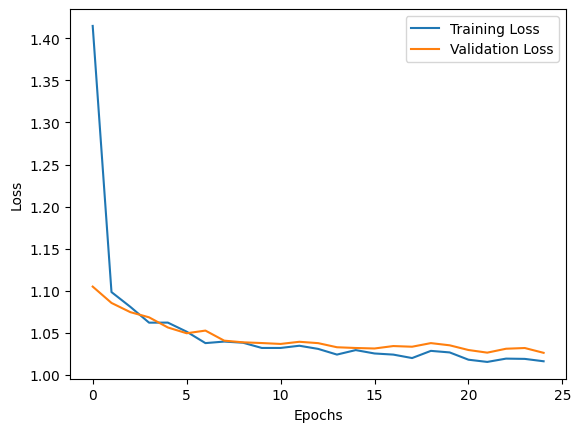

In [123]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predicciones

Obtener la exactitud del modelo

In [124]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Exactitud del modelo:", accuracy)

20/20 [==============================] - 0s 1ms/step
Exactitud del modelo: 0.5078616352201258


Comparaciones de las predicciones y valores reales (primeros 10)

In [125]:
print("Predicciones (primeros 10 elementos)  :", y_pred_labels[:10])
print("Valores reales (primeros 10 elementos):", y_test[:10].values)

Predicciones (primeros 10 elementos)  : [2 2 2 2 2 0 0 2 2 2]
Valores reales (primeros 10 elementos): [1 0 1 0 1 0 1 1 2 2]


Obtener los porcentajes de cada resultado

In [126]:
combined = pd.DataFrame({'Real': y_test, 'Prediccion': y_pred.argmax(axis=1)})
pd.crosstab(index=combined['Real'], columns=combined['Prediccion'])

Prediccion,0,2
Real,,
0,72,118
1,39,123
2,33,251


Obtener predicciones reales

In [127]:
combined = combined.merge(data[['HomeTeam', 'AwayTeam']], left_index=True, right_index=True)
combined

,Real,Prediccion,HomeTeam,AwayTeam
1027,1,2,12,9
1503,0,2,30,13
785,1,2,4,6
411,0,2,19,3
1103,1,2,12,9
...,...,...,...,...
561,1,0,9,4
282,2,2,5,2
2619,0,0,12,25
693,2,0,12,5


In [128]:
model.save('modelos/modelo2.h5')
data.to_csv('modelos/data2.csv', index=False)

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
